<a href="https://colab.research.google.com/github/hxtruong/greatmaps-vietbando/blob/master/VietBanDo_GPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


### Read data

In [0]:
link = "https://raw.githubusercontent.com/hxtruong/dataset/master/vietbando/WayPointDemo.csv"
# Note: set param encoding = 'latin1'
df = pd.read_csv(link,encoding='latin1')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599975 entries, 0 to 599974
Data columns (total 8 columns):
eventdate      599975 non-null object
vehicle        599975 non-null object
datetime       599975 non-null object
speed          599975 non-null float64
longitude      599975 non-null float64
latitude       599975 non-null float64
heading        599975 non-null float64
vehicleType    599975 non-null int64
dtypes: float64(4), int64(1), object(3)
memory usage: 36.6+ MB


In [0]:
df.describe()

speed      longitude  ...        heading    vehicleType
count  599975.000000  599975.000000  ...  599975.000000  599975.000000
mean        6.023258     106.696958  ...     115.869299     156.182174
std        10.729775       0.008335  ...     113.598963     215.934555
min         0.000000     106.681669  ...    -179.000000       0.000000
25%         0.000000     106.690150  ...       0.000000       0.000000
50%         0.000000     106.697190  ...     108.000000       0.000000
75%         9.000000     106.703350  ...     187.050000     300.000000
max       132.000000     106.715053  ...   12342.000000     900.000000

[8 rows x 5 columns]

In [0]:
df.sample(5)

eventdate   vehicle  ... heading  vehicleType
299839  01/08/2019  51G00812  ...   180.0            0
227072  01/08/2019  51F51377  ...   180.0            0
443357  01/08/2019  51G79193  ...     0.0            0
321335  01/08/2019  51G19844  ...     0.0            0
291286  01/08/2019  51F95678  ...     0.0            0

[5 rows x 8 columns]

# Preprocessing

## Filter data

#### Drop useless columns

In [0]:
df.nunique()

eventdate          1
vehicle        37282
datetime       82121
speed           2336
longitude      31367
latitude       91210
heading         6439
vehicleType       10
dtype: int64

In [0]:
df.drop(labels=['eventdate'],axis=1, inplace=True)

#### Remove vehicle apper les than STANDARD times

In [0]:
STANDARD_TIMES = 50

In [0]:
# Remove all vehicle appear less than STANDARD_TIMES times
vehicleCount = df.groupby(by='vehicle').size().rename('count').reset_index().sort_values(by=['count'], ascending= False)

In [0]:
rmIndex = np.array(vehicleCount[vehicleCount['count']<50]['vehicle'])
print(rmIndex)
print(len(rmIndex))

['51G48696' '51B15126' '51A75026' ... '60LD01955' '60LD01938' '99LD01544']
34418


In [0]:
df = df[~df['vehicle'].isin(rmIndex)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263091 entries, 381 to 599859
Data columns (total 7 columns):
vehicle        263091 non-null object
datetime       263091 non-null object
speed          263091 non-null float64
longitude      263091 non-null float64
latitude       263091 non-null float64
heading        263091 non-null float64
vehicleType    263091 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 16.1+ MB


In [0]:
# Test count vehicle again
df.groupby(by='vehicle').size().rename('count').reset_index().sort_values(by=['count'], ascending= False)

vehicle  count
517    51B27866    296
1997   51G59860    291
2634  59U124798    287
2224   51G77157    268
1519   51G04500    258
396    51B17324    255
1698   51G33790    255
2747   65A19359    251
675    51C67871    245
2782   71A04686    245
2583    54X1113    244
400    51B17924    243
2083   51G67050    233
1961   51G56199    226
231    51A39524    225
1610   51G24023    221
249    51A50529    213
395    51B17125    212
1739   51G37237    212
2820    80B5464    209
344    51B05053    209
1662   51G30518    206
2584    54X6582    202
1960   51G56050    199
948    51F23643    195
2822    80B5487    195
947    51F23560    193
1864   51G48006    192
1761   51G39585    192
2065   51G65871    191
...         ...    ...
583    51B40346     50
2465   51H09261     50
1071  51F45031A     50
2708  61LD02591     50
1044   51F42299     50
2413   51H05048     50
1255   51F67145     50
2520   51LD5599     50
339    51B02536     50
227    51A38001     50
1258   51F67351     50
2377   51H02837     50
1453   51F95920     50
2243   51G78812     50
1264   51F68500     50
2539    52Y4441     50
1527   51G06373     50
53     49A16429     50
2236   51G78053     50
2393   51H03635     50
2655   60A57800     50
106   50LD08459     50
1634   51G26870     50
684    51C71939     50
2401   51H04014     50
2665   60B02944     50
1908   51G51240     50
2775   69A06735     50
2075   51G66544     50
2596    54Y8491     50

[2864 rows x 2 columns]

#### Filter time limit between GPG less than TIME_LIMIT

In [0]:
# Milisecond
TIME_LIMIT = 10000

Convert datetime to datetime in pandas - slow


In [0]:
%%time
df['datetime'] = pd.to_datetime(df['datetime'])
df.sample(5)

CPU times: user 36.3 s, sys: 8.48 ms, total: 36.3 s
Wall time: 36.3 s


Sort value follow: vehicle, eventdate, datatime, (long, lat)

In [0]:
df = df.sort_values(by=['vehicle', 'datetime', 'longitude', 'latitude'])

In [0]:
%%time
df['diff_seconds'] = 0
df['diff_seconds'] = (df['datetime'] - df['datetime'].shift())/np.timedelta64(1,'s')
df['diff_seconds'].fillna(0,inplace=True)

CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 15.5 ms


In [0]:
print("Number of vehicle: ", df['vehicle'].nunique())
print("Len of diff_seconds < 0 : ",len(df[df['diff_seconds']<0]))

Number of vehicle:  2864
Len of diff_seconds < 0 :  2859


In [0]:
df.loc[df['vehicle']!=df['vehicle'].shift(), 'diff_seconds'] = 0

In [0]:
df['diff_seconds'].describe()

count    263091.000000
mean        799.745286
std        1833.968397
min           0.000000
25%         300.000000
50%         480.000000
75%         896.000000
max       65679.000000
Name: diff_seconds, dtype: float64

In [0]:
df['diff_mins'] = df['diff_seconds'] / 60
df['diff_mins'].describe()

count    263091.000000
mean         13.329088
std          30.566140
min           0.000000
25%           5.000000
50%           8.000000
75%          14.933333
max        1094.650000
Name: diff_mins, dtype: float64

In [0]:
df.head(10)

vehicle            datetime  speed  ...  vehicleType  diff_seconds  diff_mins
381  15B02192 2019-01-08 00:01:01   30.0  ...            0           0.0   0.000000
382  15B02192 2019-01-08 00:20:51   54.0  ...          300        1190.0  19.833333
383  15B02192 2019-01-08 00:25:51   33.0  ...          300         300.0   5.000000
384  15B02192 2019-01-08 00:30:51   30.0  ...            0         300.0   5.000000
385  15B02192 2019-01-08 01:00:51    0.0  ...          300        1800.0  30.000000
386  15B02192 2019-01-08 01:17:21    0.0  ...            0         990.0  16.500000
387  15B02192 2019-01-08 01:22:21   35.0  ...          300         300.0   5.000000
388  15B02192 2019-01-08 01:32:21    0.0  ...            0         600.0  10.000000
389  15B02192 2019-01-08 01:47:21    0.0  ...            0         900.0  15.000000
390  15B02192 2019-01-08 02:18:53    0.0  ...            0        1892.0  31.533333

[10 rows x 9 columns]

In [0]:
df.to_csv('gps.csv', index=False, encoding='utf-8')

## Split small data

In [0]:
df.info()

In [0]:
# df = df.iloc[:10000]

In [0]:
df['datetime'].describe()

count                   10000
unique                   8970
top       2019-01-08 08:48:00
freq                        4
first     2019-01-08 00:00:00
last      2019-01-08 23:59:59
Name: datetime, dtype: object

In [0]:
df.describe()

speed     longitude      latitude       heading   vehicleType
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       5.999189    106.692945     10.773949    115.436215    165.720000
std       11.332485      0.007605      0.012051    112.807992    229.800266
min        0.000000    106.681670     10.753520   -166.000000      0.000000
25%        0.000000    106.685745     10.763458      0.000000      0.000000
50%        0.000000    106.691695     10.774331    102.000000      0.000000
75%        7.000000    106.700100     10.783352    197.625000    300.000000
max       67.000000    106.704444     10.796884    360.000000    900.000000

In [0]:
# import datetime
# %time
# df['timeDiff'] = 0 #seconds
# # slow
# c=0
# for i in range(df.shape[0]-1):
#     if df['vehicle'].iloc[i+1] == df['vehicle'].iloc[i]:
#         # df['timeDiff'].iloc[i+1] = (df['datetime'].iloc[i+1]-df['datetime'].iloc[i]).total_seconds()
#         c = c + 1
# print(c)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
260227


In [0]:
g = df.groupby('vehicle').cumcount()
L = (df.set_index(['vehicle',g])
       .unstack(fill_value=0)
       .stack().groupby(level=0)
       .apply(lambda x: x.values.tolist())
       .tolist())
print (L)

[[[Timestamp('2019-01-08 00:01:01'), 30.0, 106.68231200000001, 10.7954998, 180.0, 0], [Timestamp('2019-01-08 00:20:51'), 54.0, 106.682317, 10.791277000000001, 313.0, 300], [Timestamp('2019-01-08 00:25:51'), 33.0, 106.68231899999999, 10.763646000000001, 158.0, 300], [Timestamp('2019-01-08 00:30:51'), 30.0, 106.6823196, 10.76594639, 180.0, 0], [Timestamp('2019-01-08 01:00:51'), 0.0, 106.6823196, 10.77034664, 180.0, 300], [Timestamp('2019-01-08 01:17:21'), 0.0, 106.6823196, 10.78355312, 180.0, 0], [Timestamp('2019-01-08 01:22:21'), 35.0, 106.68231999999999, 10.791260000000001, 0.0, 300], [Timestamp('2019-01-08 01:32:21'), 0.0, 106.682327, 10.764361, 218.0, 0], [Timestamp('2019-01-08 01:47:21'), 0.0, 106.682327, 10.764361, 218.0, 0], [Timestamp('2019-01-08 02:18:53'), 0.0, 106.682327, 10.764361, 218.0, 0], [Timestamp('2019-01-08 02:23:53'), 0.0, 106.682327, 10.764361, 218.0, 0], [Timestamp('2019-01-08 02:54:38'), 0.0, 106.682327, 10.764361, 218.0, 0], [Timestamp('2019-01-08 03:04:38'), 0.0

## Model

### K-Mean

In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [0]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

coords = df.as_matrix(columns=['latitude', 'longitude'])

In [0]:
kms_per_radian = 6371.0088

In [0]:
# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 0.01 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

In [0]:
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 2649


In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [0]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'longitude':lons, 'latitude':lats})

In [0]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['latitude']==row['latitude']) & (df['longitude']==row['longitude'])].iloc[0], axis=1)
rs.to_csv('gps-dbscan.csv', encoding='utf-8')
rs.tail()

vehicle            datetime  speed  ...   latitude  heading  vehicleType
2644  50LD08677 2019-01-08 13:34:59   17.0  ...  10.773050     48.0            0
2645  50LD08677 2019-01-08 20:02:53   13.0  ...  10.778099    246.0            0
2646  50LD08677 2019-01-08 20:06:23   12.0  ...  10.781718     48.0          500
2647  50LD08677 2019-01-08 20:48:23   33.0  ...  10.754766    180.0            0
2648  50LD08677 2019-01-08 20:50:53   28.0  ...  10.775175      0.0          700

[5 rows x 7 columns]

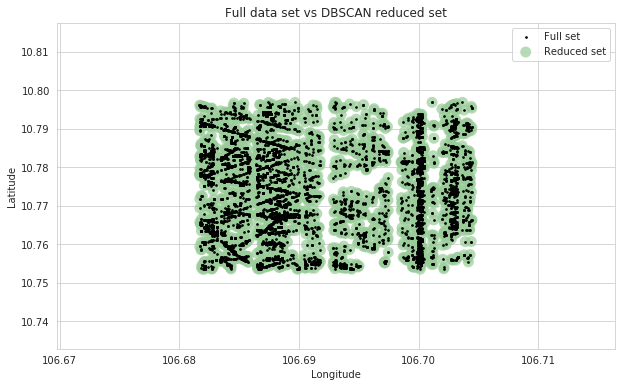

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

### Cluster gps point

In [0]:
# import necessary modules
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import time
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

In [0]:
# uncomment to cluster only a sample
# df_gps = df_gps.iloc[range(0, len(df_gps), int(len(df_gps)/5000))] 

In [0]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

#### Define the clustering functions

In [0]:
%time
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [0]:
# %xmode
%time
def dbscan_reduce(df, epsilon, x='longitude', y='latitude'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df[[y,x]].to_numpy()    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [0]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 0.005 / kms_per_radian
df_clustered = dbscan_reduce(df, epsilon=eps_rad)

Number of clusters: 32,678
Clustered 263,091 points down to 32,678 points, for 87.58% compression in 128.23 seconds.


In [0]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32678 entries, 0 to 32677
Data columns (total 7 columns):
vehicle        32678 non-null object
datetime       32678 non-null datetime64[ns]
speed          32678 non-null float64
longitude      32678 non-null float64
latitude       32678 non-null float64
heading        32678 non-null float64
vehicleType    32678 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.7+ MB


The previous clustering reduces dense clusters of points to a single point. Because min_samples=1, no point is noise - if there was a single gps reading in the middle of nowhere, it will be retained as a cluster/point. If the points were too dense along a linear strip, such as a highway, it will remove the entire line of points and leave just one behind, in the middle. To fix this, let's thin out the data set by retaining every *n*th point as df_sampled. Then, combine df_sampled with df_clustered, and re-cluster once again to reduce the thinned-out data set. The final product will retain lonely points in the middle of nowhere (that would otherwise possibly be lost by merely sampling every *n*th point) and will not strip out long linear corridors of dense points (that were removed in the first clustering step).

In [0]:
# next, sample every nth row (where n=sample_rate) of the full gps location history data set
sample_rate = 20
df_sampled = df.iloc[range(0, len(df), sample_rate)]
len(df_sampled)

13155

In [0]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [0]:
# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.001 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad)

Number of clusters: 41,565
Clustered 45,833 points down to 41,565 points, for 9.31% compression in 87.10 seconds.


In [0]:
# save to csv
df_final.to_csv('gps-clustered.csv', index=False, encoding='utf-8')

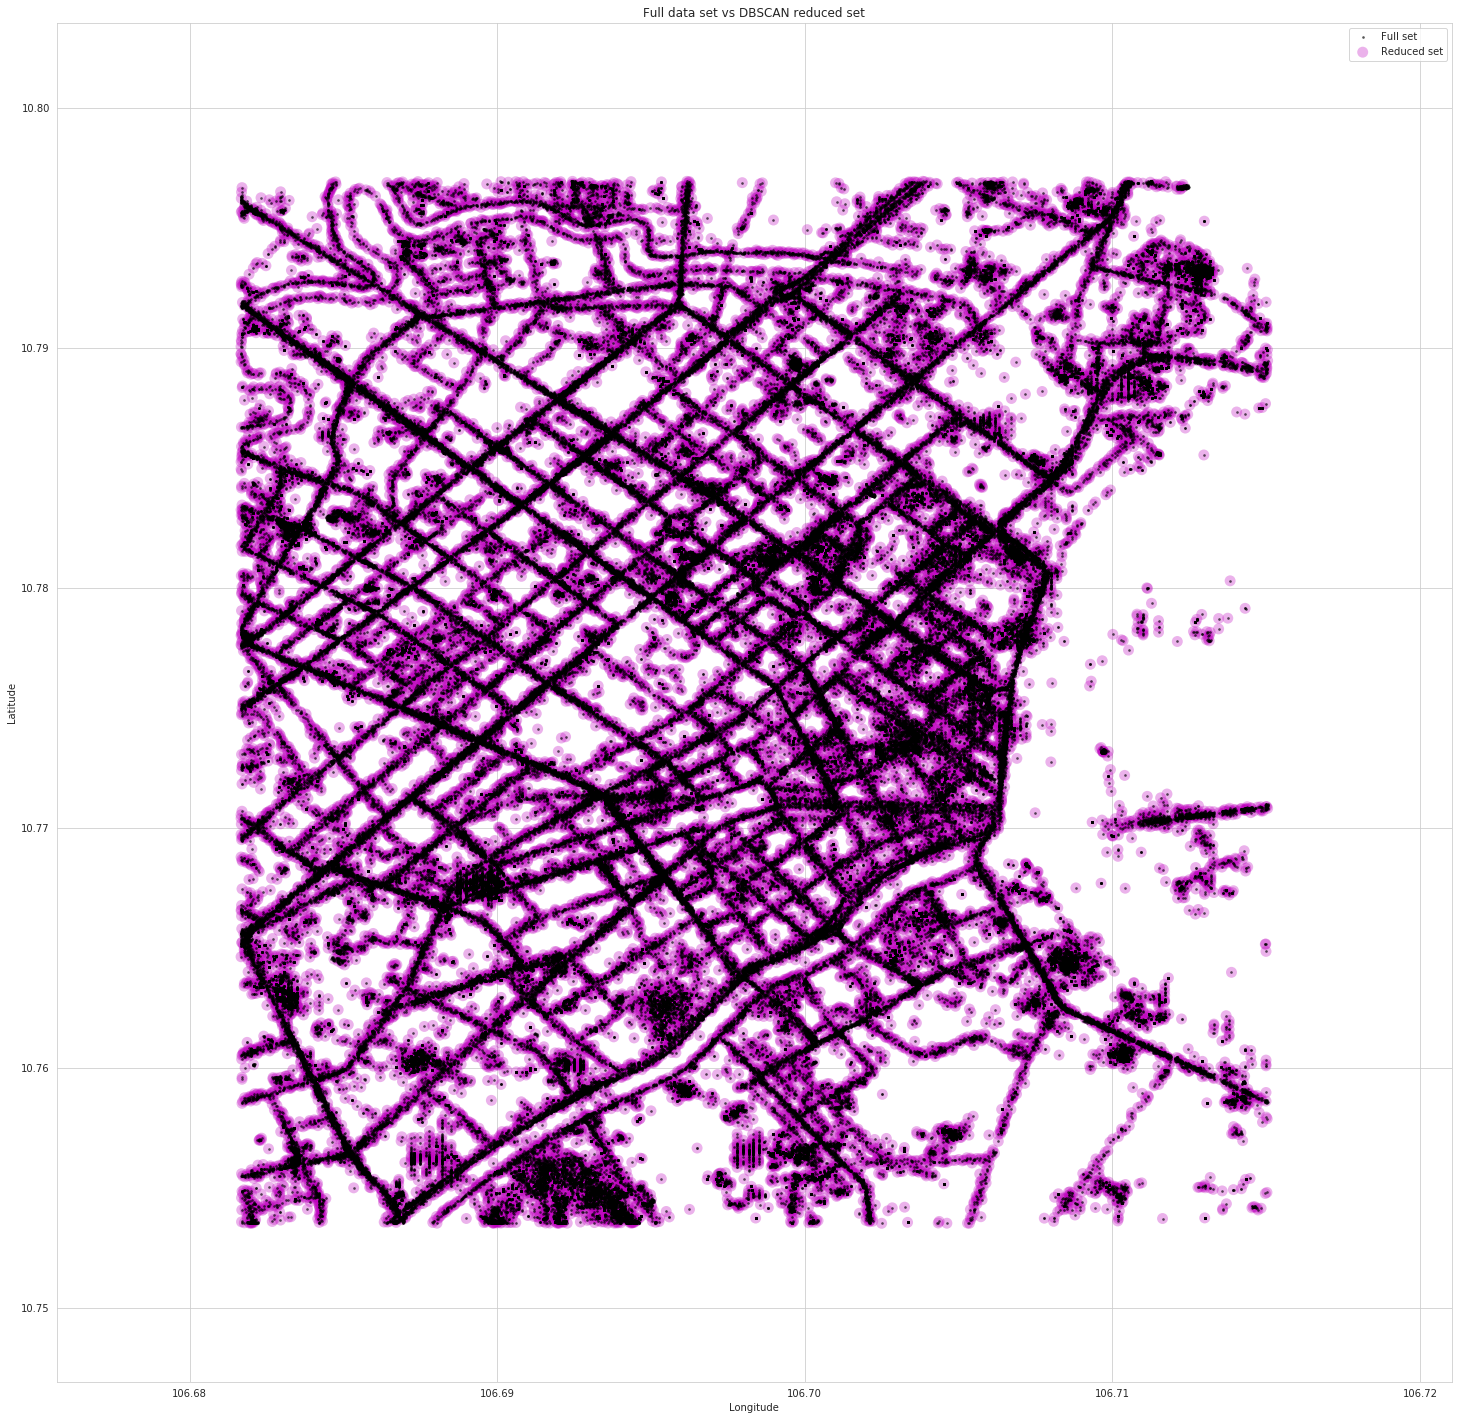

CPU times: user 4.59 s, sys: 329 ms, total: 4.92 s
Wall time: 4.55 s


In [0]:
# show a map of the worldwide data points
%%time
fig, ax = plt.subplots(figsize=[25,25])
rs_scatter = ax.scatter(df_final['longitude'], df_final['latitude'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

## Visualize data

### Display point by plt

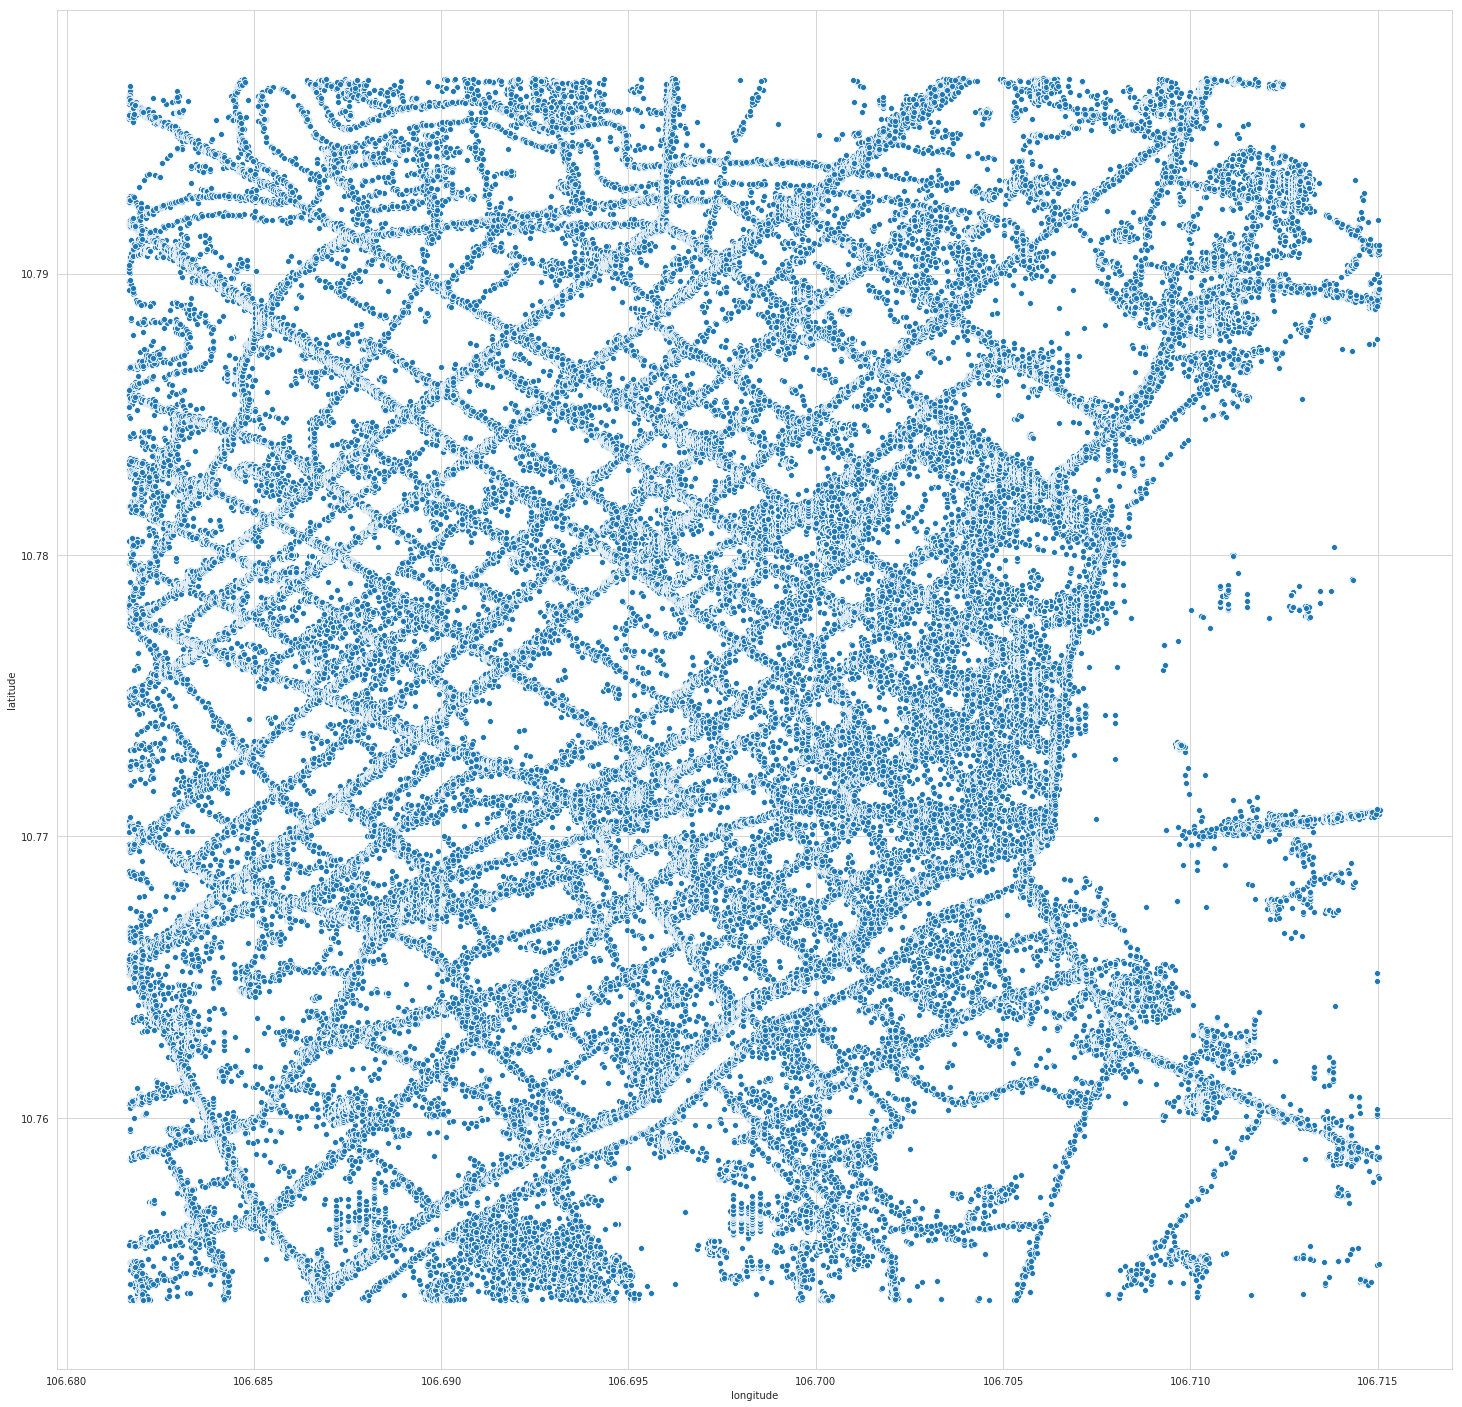

In [0]:
fig = plt.figure(figsize=(25, 25))
sns.scatterplot(x='longitude', y='latitude', data=df)
plt.show()

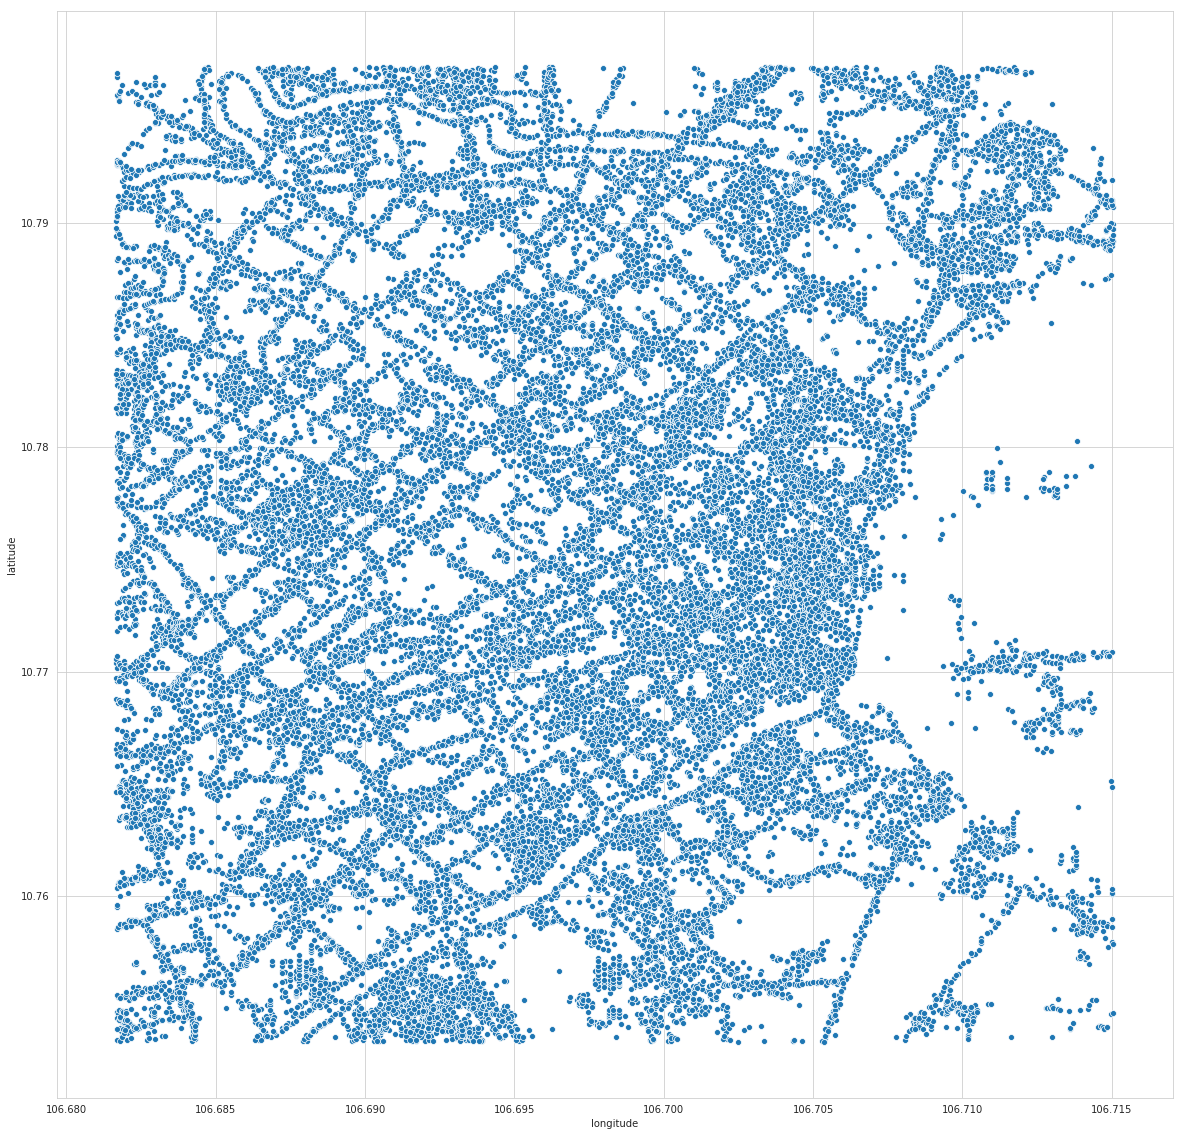

In [0]:
# rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fig = plt.figure(figsize=(20, 20))
sns.scatterplot(x='longitude', y='latitude', data=df_clustered)
plt.show()

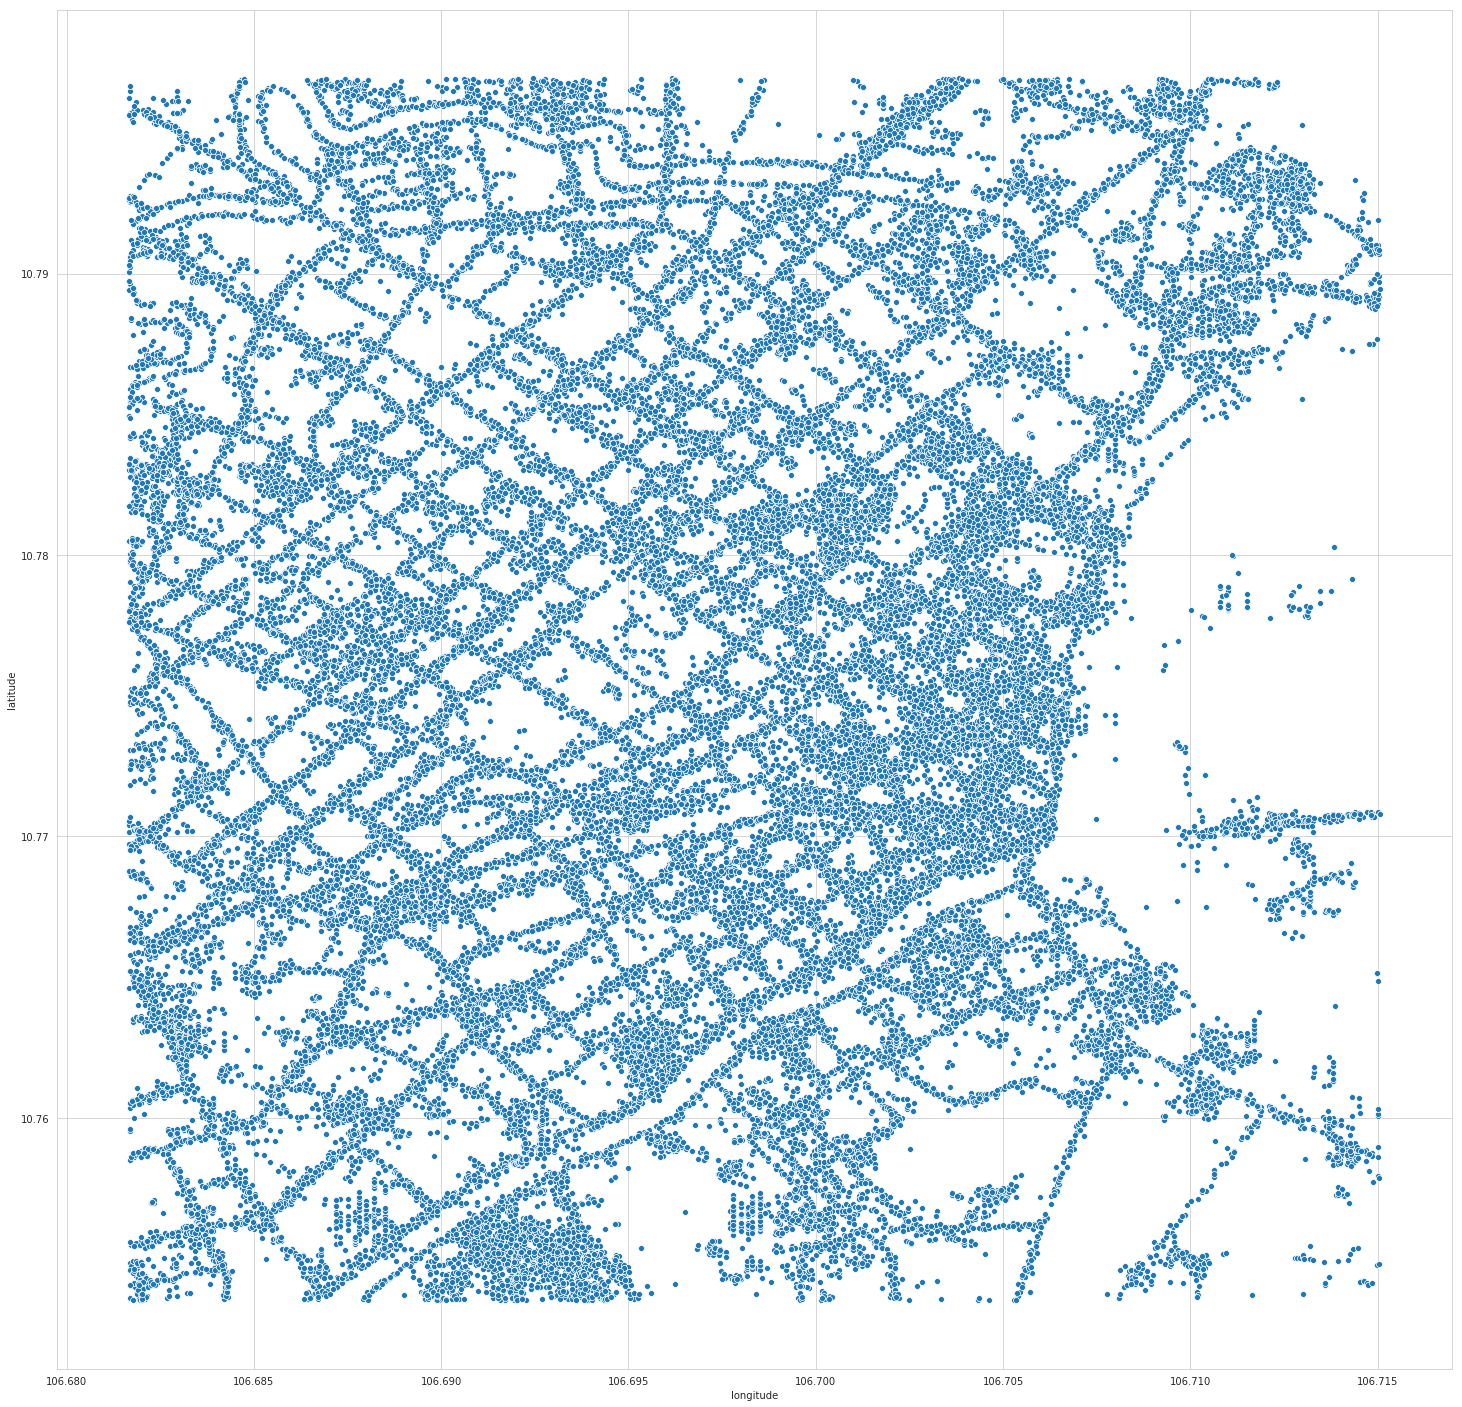

CPU times: user 1.87 s, sys: 248 ms, total: 2.12 s
Wall time: 1.87 s


In [0]:
%%time
fig = plt.figure(figsize=(25, 25))
sns.scatterplot(x='longitude', y='latitude', data=df_final)
plt.show()

### Gmap display

In [0]:
# !pip install gmplot

In [0]:
from gmplot import gmplot
import webbrowser, os, json

In [0]:
# Place map
gmap = gmplot.GoogleMapPlotter(37.766956, -122.438481, 13)

# Polygon
golden_gate_park_lats, golden_gate_park_lons = zip(*[
    (37.771269, -122.511015),
    (37.773495, -122.464830),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347),
    (37.771269, -122.511015)
    ])
gmap.plot(golden_gate_park_lats, golden_gate_park_lons, 'cornflowerblue', edge_width=10)

# Scatter points
top_attraction_lats, top_attraction_lons = zip(*[
    (37.769901, -122.498331),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
    ])
gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=40, marker=False)

# Marker
hidden_gem_lat, hidden_gem_lon = 37.770776, -122.461689
gmap.marker(hidden_gem_lat, hidden_gem_lon, 'cornflowerblue')

# Draw
gmap.draw("my_map.html")

In [0]:
gmap = gmplot.GoogleMapPlotter.from_geocode("San Francisco")

IndexError: ignored

### Open new tab for gmap

In [0]:
filename = 'file:///'+os.getcwd()+'/' + 'my_map.html'
webbrowser.open_new('./my_map.html')
# webbrowser.get(chrome_path).open(url)


False

In [0]:
!ls

my_map.html  sample_data


## Processing #2

In [0]:
df2 = df_final

In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41565 entries, 0 to 41564
Data columns (total 7 columns):
vehicle        41565 non-null object
datetime       41565 non-null datetime64[ns]
speed          41565 non-null float64
longitude      41565 non-null float64
latitude       41565 non-null float64
heading        41565 non-null float64
vehicleType    41565 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.2+ MB


In [0]:
df2.head()

vehicle            datetime  speed  ...   latitude  heading  vehicleType
0  51A15721 2019-01-08 21:50:01   10.0  ...  10.795753    306.0            0
1  51B30036 2019-01-08 20:06:34   10.0  ...  10.791017    180.0          300
2  15B02192 2019-01-08 03:46:41   28.0  ...  10.763730      0.0            0
3  51A15259 2019-01-08 06:27:30    8.0  ...  10.765574      0.0            0
4  51B18817 2019-01-08 18:26:20    0.0  ...  10.770338      0.0          300

[5 rows x 7 columns]

In [0]:
df2.describe()

speed     longitude      latitude       heading   vehicleType
count  41565.000000  41565.000000  41565.000000  41565.000000  41565.000000
mean       7.260192    106.696497     10.775412    114.331681    162.297606
std       11.361511      0.008251      0.011866    110.775365    217.985599
min        0.000000    106.681669     10.753520   -176.000000      0.000000
25%        0.000000    106.689682     10.765768      0.000000      0.000000
50%        0.000000    106.696602     10.775320    110.000000      0.000000
75%       13.000000    106.703033     10.785075    180.000000    300.000000
max      132.000000    106.715050     10.796933    508.000000    900.000000

In [0]:
v_df = df2.groupby(by='vehicle').size().rename('count').reset_index().sort_values(by=['count'], ascending= False)
v_df

vehicle  count
675    51C67871     70
2746   65A19359     65
836    51D48754     55
2082   51G67050     52
1960   51G56199     50
2813   77C14725     49
704    51C85731     49
1996   51G59860     48
1647   51G29130     47
883    51F07928     47
1778   51G41063     44
1863   51G48006     44
1709   51G34859     44
139   50LD10921     43
1212   51F61826     42
1760   51G39585     42
231    51A39524     42
2781   71A04686     42
2287   51G86311     41
2236   51G78203     41
2600    54Z6268     41
517    51B27866     41
421    51B19156     40
2050   51G64806     40
5      29A60023     40
1444   51F94806     40
1000   51F34449     40
1175   51F55963     40
1282   51F70416     40
2582    54X1113     40
...         ...    ...
1225   51F63493      2
1724   51G36000      2
2645   60A37840      2
154   50LD12081      2
2566    54T4374      2
1993   51G59557      2
2558    54L8557      2
1462   51F97329      2
480    51B24673      2
2614    57L3781      2
619    51C15729      2
2624    57L7284      2
1607   51G23806      2
1602   51G23091      2
1680   51G32383      2
1676   51G32014      2
61     50A00804      2
721    51C97713      2
992    51F33377      2
2696   61B01976      1
1111   51F50462      1
1517   51G04191      1
189    51A03339      1
2554    53S5496      1
2695   61B01957      1
735    51D02275      1
2725   63A09109      1
1577   51G18060      1
2400   51H04014      1
1134   51F51496      1

[2863 rows x 2 columns]

In [0]:
v_df 

count
count  2863.000000
mean     14.517988
std       7.651494
min       1.000000
25%       9.000000
50%      13.000000
75%      18.000000
max      70.000000